# 1D Deconvolution with wavelets


In [14]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

from context import samplers as samplers,utils


Display $f =\Phi u + w$ where $u$ is a piecewise constant signal, $\Phi$ is a convolution operator, and $s$ is some random Gaussian noise.



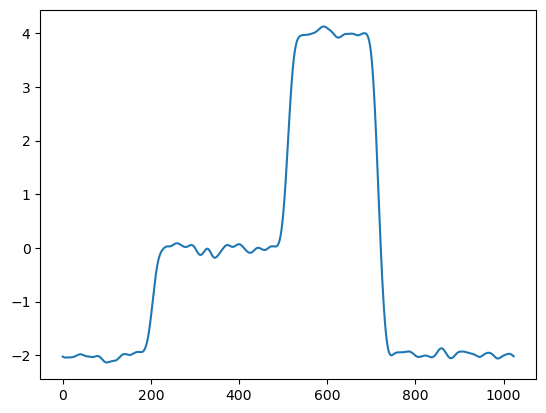

In [15]:
from skimage.util import random_noise
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

p=1024 #signal length

#define convolution operator
s = 8
h = utils.GaussianFilter(s,p)
Phi = lambda x: np.real(ifft(fft(x)*fft(h))); 
Phi_s = lambda x: np.real(ifft(fft(x)*np.conjugate(fft(h))))


#measurements
t = np.linspace(-2.5, 2.5, p)
x0 = np.piecewise(t, [t < -1.5, t >= 0,t>1], [-2, 4,-2])
b = Phi(x0)

# add noise
sigma = .1;
b = random_noise(b,mode='gaussian',var=sigma,clip=False)

plt.plot(Phi_s(b))
plt.show()



We will consider the regularisation
$$
R_\alpha(f)  := \mathrm{argmin}_u \frac12 \| \Phi u - f\|^2 + \alpha\|D W u\|_1
$$
where $W$ is the discrete wavelet transform and $D$ is a diagonal matrix (giving higher weights to wavelets of higher frequency). Note that since $W^* = W^{-1}$, we can rewrite this as $R_\alpha(f) = W^* D^{-1} z_\alpha$ where
$$
z_\alpha  := \mathrm{argmin}_z \frac12 \| A z - f\|^2 + \alpha\|z\|_1.
$$
where $A:= \Phi\circ W^* D^{-1}$.


In [48]:
#define the operator A
lev = int(np.log2(p))-1
py_W, py_Ws, scaling_vec = utils.getWaveletTransforms(p,wavelet_type = "haar",level = lev,weight=.7)

# A =  Phi o W^{-1}
A = lambda coeffs: Phi(py_Ws(scaling_vec*coeffs))

# adjoint operator A^* =  W o Phi 
As = lambda x: scaling_vec*py_W(Phi_s(x))



Compute the MAP using FISTA

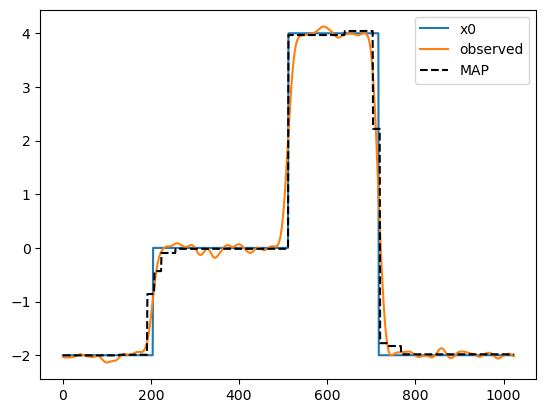

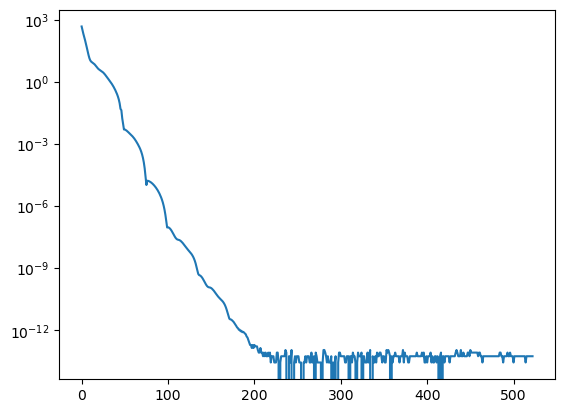

In [54]:
#Run FISTA
prox = lambda x, tau: np.maximum(np.abs(x)-tau, np.zeros_like(x))*np.sign(x)

lam = .2
mfunc = lambda x: .5* np.linalg.norm(A(x)-b)**2 + lam*np.linalg.norm(x,ord=1)
dG = lambda x: As(A(x) - b)
proxF = lambda x,tau: prox(x,tau*lam)

tau = 1
nIter =1000
xinit = As(b)
x_mode,fval = utils.rFISTA(proxF, dG, tau, xinit,nIter,mfunc)
plt.plot(x0,label='x0')

plt.plot(Phi_s(b),label='observed')
plt.plot(py_Ws(scaling_vec*x_mode),'k--',label='MAP')

plt.legend()
plt.show()

plt.semilogy(fval-min(fval))

## Run proximal langevin and Hadamard langevin

In [55]:
#defined the gradient of  Moreau-envelope of the density
def soft(x,tau): 
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)

#Run proximal langevin


Lf = 10
gamma = 1/Lf
tau = gamma/5/(Lf*gamma+1)
print('stepsize ',tau)

grad_F = lambda x:  dG(x) + (x - soft(x,lam*gamma))/gamma
mfunc = lambda x: .5* np.linalg.norm(A(x)-b)**2 + lam*np.linalg.norm(x,ord=1)

Iterate = lambda x: samplers.one_step_langevin(x,p, grad_F, tau,beta=5)

xinit = np.random.randn(p,)
n = int(1e5)
burn_in = int(1e4)

print('Running prox-l1 sampler ...\n')
samples_proxl1 = samplers.generate_samples_x(Iterate, xinit, n, burn_in)


stepsize  0.01
Running prox-l1 sampler ...



In [57]:
uvinit = np.concatenate((np.abs( np.random.rand(p,)),np.random.randn(p,)))
Iterate_uv = lambda x: samplers.one_step_hadamard(x, p,dG, tau, lam,beta=5)

print('Running hadamard sampler ...\n')
samples_uv = samplers.generate_samples_x(Iterate_uv, uvinit, n, burn_in)

Running hadamard sampler ...



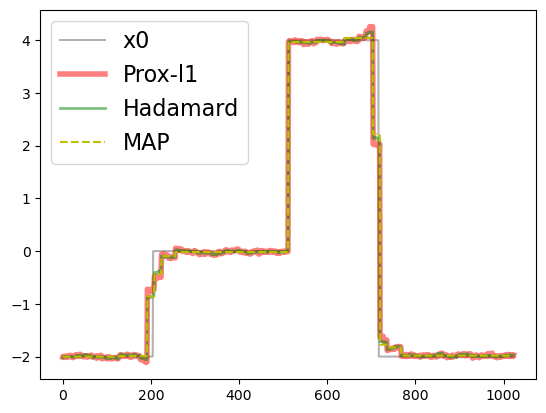

In [72]:

plt.plot(x0, 'k',label='x0', alpha=0.3)


plt.plot(py_Ws(scaling_vec*np.mean(samples_proxl1,axis=0)), 'r', label='Prox-l1',linewidth=4.0,alpha=0.5)
plt.plot(py_Ws(scaling_vec*np.mean(samples_uv[:,:p]*samples_uv[:,p:], axis=0)), 'g-',label='Hadamard',linewidth=2.0,alpha=0.5)

plt.plot(py_Ws(scaling_vec*x_mode), 'y--', label='MAP')

signal_samples = np.stack([py_Ws(scaling_vec*x) for x in samples_proxl1],axis=0)
signal_samples_uv = np.stack([py_Ws(scaling_vec*x) for x in samples_uv[:,:p]*samples_uv[:,p:]],axis=0)

plt.legend(fontsize=16)

plt.savefig('results/Deconv_mean.pdf', bbox_inches='tight')




Plot the difference between the 95 and 5 percentiles

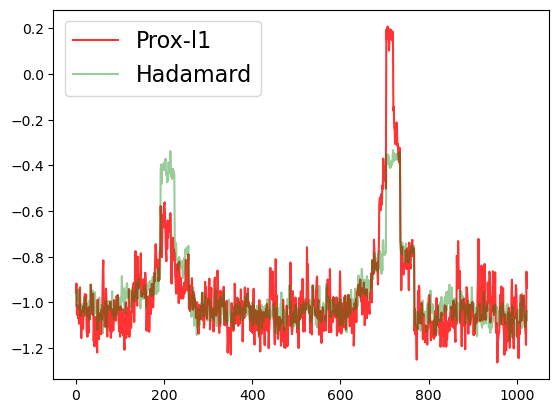

In [73]:

# Calculate 90% credibility intervals (pixel-wise)
lower_bound = np.percentile(signal_samples, 5, axis=0)
upper_bound = np.percentile(signal_samples, 95, axis=0)
plt.plot(np.log(upper_bound-lower_bound), 'r', alpha=0.8, label='Prox-l1')


lower_bound = np.percentile(signal_samples_uv, 5, axis=0)
upper_bound = np.percentile(signal_samples_uv, 95, axis=0)
plt.plot(np.log(upper_bound-lower_bound), 'g-',alpha=0.4, label='Hadamard')
plt.legend(fontsize=16)

plt.savefig('results/Deconv_quantile.pdf', bbox_inches='tight')


Check the effective sample size

In [77]:
import arviz as az


idata = az.convert_to_inference_data(np.expand_dims(signal_samples, 0))
ess = az.ess(idata)


idata_uv = az.convert_to_inference_data(np.expand_dims(signal_samples_uv, 0))
ess_uv = az.ess(idata_uv)

1.4188756738327672
12.56526233782412
[0]


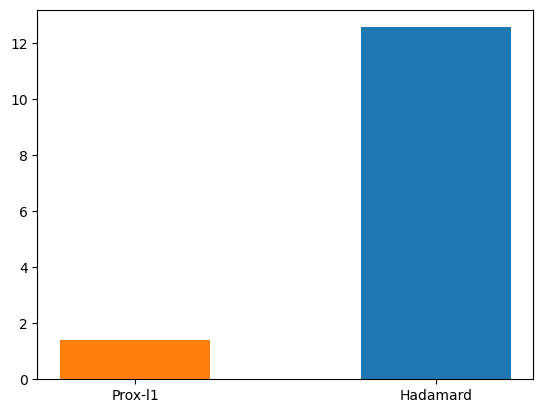

In [78]:
ess_values = (ess['x'].values).min()
print(ess_values)
width=0.2
# x = np.arange(len(ess_values))
x = np.arange(1)

fig, ax = plt.subplots()



ess_uv_values = (ess_uv['x'].values).min()
print(ess_uv_values)
width=0.2

rects1 = ax.bar(x +width, ess_uv_values, width, label='Hadamard')
print(x)
ax.set_xticks([-width,width])
ax.set_xticklabels(['Prox-l1', 'Hadamard'])
rects1 = ax.bar(x -width, ess_values, width, label='Prox-l1')

plt.savefig('results/Deconv_ESS_min.pdf', bbox_inches='tight')


# plt.legend()

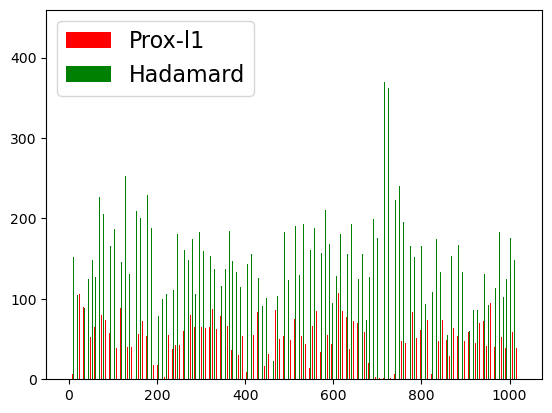

In [87]:
width=0.2
# x = np.arange(1)

fig, ax = plt.subplots()




ess_uv_values = (ess_uv['x'].values)

x = np.arange(len(ess_uv_values))




ess_values = (ess['x'].values)
rects1 = ax.bar(x -width, ess_values,width, label='Prox-l1',color='r')
rects1 = ax.bar(x +width, ess_uv_values, width, label='Hadamard',color='g')

plt.legend(fontsize=16)
plt.savefig('results/Deconv_ESS.pdf', bbox_inches='tight')


In [75]:
np.exp(1.4188756738327672),np.exp(12.56526233782412)

(4.1324715813899795, 286433.6894248724)